In [1]:
! nvidia-smi

Sun May 30 09:18:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Introduction

This notebook holds the code for the [Involution](https://arxiv.org/abs/2103.06255) layer in tesorflow. The idea behind this layer is to invert the inherent properties of Convolution. Where convolution is spatial-agnostic and channel-specific, involution is spatial-specific and channel-agnostic.

# Imports

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Convolution
To understand involution we need to first understand convolution. Let us consider $X\in\mathbb{R}^{H\times W\times C_{inp}}$ denote the input feature map where $H, W$ represent its height and width and $C_{inp}$ be its channel size. A collection of $C_{out}$ number of convolution filters with fixed kernel size of $K \times K$ is denoted as $\mathcal{F}\in\mathbb{R}^{C_{out}\times C_{inp}\times K\times K}$.

The filters perform a Multiply-Add operation on the input feature map in a sliding window manner to yeild the output feature map $Y\in \mathbb{R}^{H\times W\times C_{out}}$.

# Involution
Involution kernels $\mathcal{H}\in \mathbb{R}^{H\times W\times K\times K\times G}$ are devised to oprate in a symettrically oppposite manner as that of the convolution kernels. Observing the shape of the involution kernels we observe the following things:
- Each pixel of the input feature map is entitled to get its own involution kernel.
- Each kernel is of the shape of $K\times K\times G$.
- The output $Y$ will be of the same shape as that of the input feature map $X$.

The problem with involution is that we cannot define a fixed shaped kernel, that would hurt resolution independence in the neural network. This thought led the researchers to conceptualize a generation function $\phi$ that generates the involution kernels conditioned on the original input tensor.
$$
\mathcal{H}_{ij}=\phi{(X_{ij})}\\
\mathcal{H}_{ij}=W_{1}\sigma{(W_{0}X_{ij})}\\
$$


In [3]:
class Involution(tf.keras.layers.Layer):
    def __init__(self, channel, group_number, kernel_size, stride, reduction_ratio):
        super().__init__()
        # The assert makes sure that the user knows about the
        # reduction size. We cannot have 0 filters in Conv2D.
        assert reduction_ratio <= channel, print("Reduction ration must be less than or equal to channel size")
        
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

        self.o_weights = tf.keras.layers.AveragePooling2D(
            pool_size=self.stride,
            strides=self.stride,
            padding="same") if self.stride > 1 else tf.identity
        self.kernel_gen = tf.keras.Sequential([
            tf.keras.layers.Conv2D(
                filters=self.channel//self.reduction_ratio,
                kernel_size=1),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(
                filters=self.kernel_size*self.kernel_size*self.group_number,
                kernel_size=1)
        ])

    def call(self, x):
        _, H, W, C = x.shape
        H = H//self.stride
        W = W//self.stride
        # Extract input feature blocks
        unfolded_x = tf.image.extract_patches(
            images=x,
            sizes=[1,self.kernel_size,self.kernel_size,1],
            strides=[1,self.stride,self.stride,1],
            rates=[1,1,1,1],
            padding="SAME")                                                     # B, H, W, K*K*C
        unfolded_x = tf.keras.layers.Reshape(
            target_shape=(H,
                   W,
                   self.kernel_size*self.kernel_size,
                   C//self.group_number,
                   self.group_number)
            )(unfolded_x)                                                       # B, H, W, K*K, C//G, G

        # generate the kernel
        kernel_inp = self.o_weights(x)
        kernel = self.kernel_gen(kernel_inp)                                    # B, H, W, K*K*G
        kernel = tf.keras.layers.Reshape(
            target_shape=(H,
                   W,
                   self.kernel_size*self.kernel_size,
                   1,
                   self.group_number)
            )(kernel)                                                           # B, H, W, K*K, 1, G

        # Multiply-Add op
        out = tf.math.multiply(kernel, unfolded_x)                              # B, H, W, K*K, C//G, G
        out = tf.math.reduce_sum(out, axis=3)                                   # B, H, W, C//G, G
        out = tf.keras.layers.Reshape(
            target_shape=(H,
                W,
                C)
        )(out)                                                                  # B, H, W, C
        return out


# Comparison
In this section we will try and emulate [TensorFlow's tutorial on CIFAR classification](https://www.tensorflow.org/tutorials/images/cnn). Here we build one model with convolutional layers while the other will be based on involuitonal layers.

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 4s 0us/step


In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(256).batch(256)
test_ds = tf.data.Dataset.from_tensor_slices( (test_images, test_labels)).batch(256)

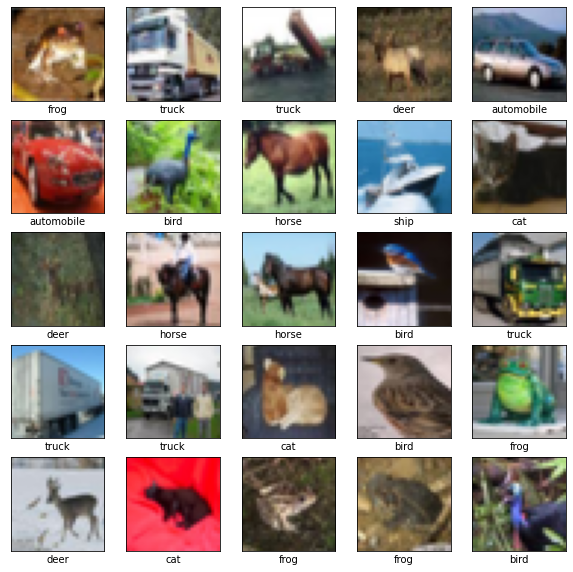

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Convolutional Neural Network

In [7]:
convolution_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10),
])

convolution_model.summary()

convolution_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [8]:
conv_history = convolution_model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds
)

Epoch 1/10
196/196 [==============================] - 35s 17ms/step - loss: 1.6127 - accuracy: 0.4195 - val_loss: 1.3434 - val_accuracy: 0.5191
Epoch 2/10
196/196 [==============================] - 4s 20ms/step - loss: 1.2374 - accuracy: 0.5598 - val_loss: 1.1291 - val_accuracy: 0.5972
Epoch 3/10
196/196 [==============================] - 4s 20ms/step - loss: 1.0686 - accuracy: 0.6246 - val_loss: 1.0573 - val_accuracy: 0.6282
Epoch 4/10
196/196 [==============================] - 4s 20ms/step - loss: 0.9704 - accuracy: 0.6604 - val_loss: 0.9692 - val_accuracy: 0.6632
Epoch 5/10
196/196 [==============================] - 4s 20ms/step - loss: 0.8862 - accuracy: 0.6884 - val_loss: 0.9245 - val_accuracy: 0.6818
Epoch 6/10
196/196 [==============================] - 4s 20ms/step - loss: 0.8285 - accuracy: 0.7115 - val_loss: 0.9081 - val_accuracy: 0.6870
Epoch 7/10
196/196 [==============================] - 4s 20ms/step - loss: 0.7633 - accuracy: 0.7349 - val_loss: 0.8745 - val_accuracy: 0.703

### Loss plot

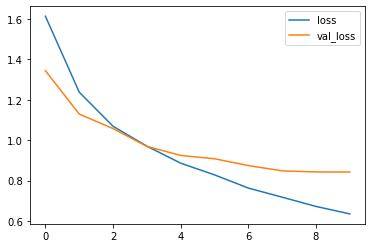

In [9]:
plt.plot(conv_history.history["loss"], label="loss")
plt.plot(conv_history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

### Accuracy plot

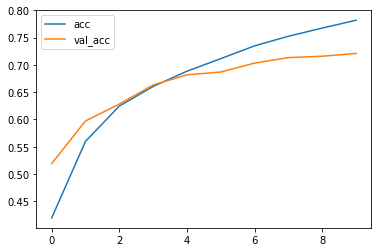

In [10]:
plt.plot(conv_history.history["accuracy"], label="acc")
plt.plot(conv_history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

# Involutional Neural Network

In [11]:
involution_model = tf.keras.models.Sequential([
    Involution(channel=3,group_number=1,kernel_size=3,stride=1,reduction_ratio=2),
    tf.keras.layers.ReLU(name="relu1"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Involution(channel=3,group_number=1,kernel_size=3,stride=1,reduction_ratio=2),
    tf.keras.layers.ReLU(name="relu2"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Involution(channel=3,group_number=1,kernel_size=3,stride=1,reduction_ratio=2),
    tf.keras.layers.ReLU(name="relu3"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10),
])

involution_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [12]:
inv_history = involution_model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds
)

Epoch 1/10
196/196 [==============================] - 6s 23ms/step - loss: 2.1900 - accuracy: 0.1784 - val_loss: 2.0711 - val_accuracy: 0.2487
Epoch 2/10
196/196 [==============================] - 4s 22ms/step - loss: 1.9197 - accuracy: 0.3157 - val_loss: 1.8661 - val_accuracy: 0.3341
Epoch 3/10
196/196 [==============================] - 4s 22ms/step - loss: 1.8176 - accuracy: 0.3521 - val_loss: 1.7955 - val_accuracy: 0.3589
Epoch 4/10
196/196 [==============================] - 4s 22ms/step - loss: 1.7675 - accuracy: 0.3711 - val_loss: 1.7578 - val_accuracy: 0.3755
Epoch 5/10
196/196 [==============================] - 4s 22ms/step - loss: 1.7373 - accuracy: 0.3849 - val_loss: 1.7354 - val_accuracy: 0.3858
Epoch 6/10
196/196 [==============================] - 4s 22ms/step - loss: 1.7105 - accuracy: 0.3934 - val_loss: 1.7033 - val_accuracy: 0.3974
Epoch 7/10
196/196 [==============================] - 4s 22ms/step - loss: 1.6896 - accuracy: 0.4013 - val_loss: 1.6769 - val_accuracy: 0.4096

In [13]:
involution_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
involution (Involution)      (None, 32, 32, 3)         26        
_________________________________________________________________
relu1 (ReLU)                 (None, 32, 32, 3)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 3)         0         
_________________________________________________________________
involution_1 (Involution)    (None, 16, 16, 3)         26        
_________________________________________________________________
relu2 (ReLU)                 (None, 16, 16, 3)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 3)           0         
_________________________________________________________________
involution_2 (Involution)    (None, 8, 8, 3)          

### Loss Plot

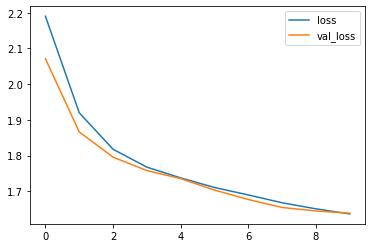

In [14]:
plt.plot(inv_history.history["loss"], label="loss")
plt.plot(inv_history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

### Accuracy Plot

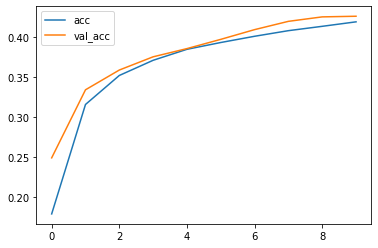

In [15]:
plt.plot(inv_history.history["accuracy"], label="acc")
plt.plot(inv_history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

### Observation

A fun little experiment is to see the activation maps of the involution kernel.

In [16]:
layer_names = ["relu1","relu2","relu3"]
outputs = [involution_model.get_layer(name).output for name in layer_names]

vis_model = tf.keras.Model(involution_model.input, outputs)

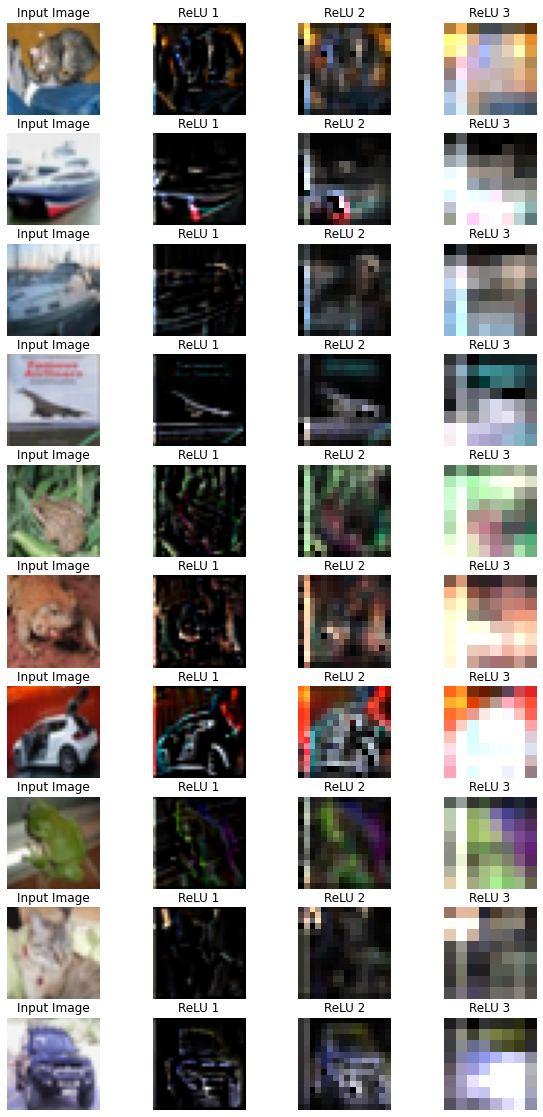

In [18]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 20))
[ax.axis("off") for ax in np.ravel(axes)]

for (ax_orig, ax_relu1, ax_relu2, ax_relu3), test_image in zip(axes, test_images[:10]):
    
    relu_images_list = vis_model.predict(tf.expand_dims(test_image,0))
    
    ax_orig.imshow(tf.clip_by_value(test_image, 0, 1))
    ax_orig.set_title("Input Image")

    ax_relu1.imshow(tf.clip_by_value(relu_images_list[0].squeeze(), 0, 1))
    ax_relu1.set_title("ReLU 1")

    ax_relu2.imshow(tf.clip_by_value(relu_images_list[1].squeeze(), 0, 1))
    ax_relu2.set_title("ReLU 2")

    ax_relu3.imshow(tf.clip_by_value(relu_images_list[2].squeeze(), 0, 1))
    ax_relu3.set_title("ReLU 3")